In [ ]:
import numpy
import threading
import csv
import pandas as pd
from rpforest import RPForest

def leaves(predict, leaf):
    treeleaves = predict[0:leaf]
    return treeleaves


def missrateav(n, k, model, data, labels, leaf):
    miss = 0
    for i in range(n):
        count = 0
        predict = model.get_candidates(data[i], number=k, normalise=False)
        treeleaves = leaves(predict, leaf)
        for j in range(leaf):
            if labels[treeleaves[j]] == labels[i]:
                count = count + 1
        if count < k:
            miss = miss + k - count
    return miss / (n*k)


def discrepancyav(n, k, model, data):
    dist = 0
    for i in range(n):
        predict = model.get_candidates(data[i], number=k, normalise=False)
        dist = dist + numpy.linalg.norm(data[i] - data[predict[k-1]])
    return dist / n


def evaluate(data, labels, n, k, t, leaf, steps, runs, avmra, avdia):
    global rc
    for r in range(runs):
        mra = numpy.empty(steps, dtype=float)
        dia = numpy.empty(steps, dtype=float)
        for i in range(steps):
            model = RPForest(leaf_size=leaf, no_trees=t)
            model.fit(data, normalise=False)
            miss = 0
            mra[i] = missrateav(n, k, model, data, labels, leaf)
            dia[i] = discrepancyav(n, k, model, data)
            model.clear()
            if t == 100:
                t = 10
            elif i == 0:
                t = t + 10
            else:
                t = t + 20
        for w in range(steps):
            avmra[w] = avmra[w] + mra[w]
            avdia[w] = avdia[w] + dia[w]
        rc = rc + 1
        if rc == 1:
            print(str(rc) + ' Execution Out of ' + str(run) + ' Completed Successfully!')
        else:
            print(str(rc) + ' Executions Out of ' + str(run) + ' Completed Successfully!')


def normalise(avdia, avdiatemp, steps):
    minim = numpy.min(avdiatemp)
    maxim = numpy.max(avdiatemp)
    for s in range(steps):
        avdia[s] = (avdiatemp[s] - minim) / (maxim - minim)


In [ ]:
data = pd.read_csv('/Users/keke/Downloads/data/iris.data', sep=',').values
data = numpy.ascontiguousarray(data)
labels = data[:,-1]
data =  numpy.ascontiguousarray(data[:,:-1])
data = data.astype('double')

In [ ]:
all_data = pd.read_csv('/Users/keke/Downloads/gisette_train.data', sep=' ').values
all_labels = pd.read_csv('/Users/keke/Downloads/gisette_train.labels', sep=' ').values

In [ ]:
unique, counts = numpy.unique(all_labels , return_counts=True)
dict(zip(unique, counts))

In [ ]:
data = all_data[0:500,0:500]
labels = all_labels[0:500,:]
data = numpy.ascontiguousarray(data)
data = data.astype('double')

In [ ]:
data.flags

In [ ]:
data.shape

In [ ]:
n = data.shape[0]
k = 5
t = 10
leaf = 20
steps = 6
run = 100
threads = 4
rc = 0
t1avmra = numpy.zeros(steps, dtype=float)
t1avdia = numpy.zeros(steps, dtype=float)
t2avmra = numpy.zeros(steps, dtype=float)
t2avdia = numpy.zeros(steps, dtype=float)
t3avmra = numpy.zeros(steps, dtype=float)
t3avdia = numpy.zeros(steps, dtype=float)
t4avmra = numpy.zeros(steps, dtype=float)
t4avdia = numpy.zeros(steps, dtype=float)
avmra = numpy.zeros(steps, dtype=float)
avdiatemp = numpy.zeros(steps, dtype=float)
avdia = numpy.zeros(steps, dtype=float)

t1 = threading.Thread(target=evaluate, args=(data, labels, n, k, t, leaf, steps, int(run / threads), t1avmra, t1avdia))
t2 = threading.Thread(target=evaluate, args=(data, labels, n, k, t, leaf, steps, int(run / threads), t2avmra, t2avdia))
t3 = threading.Thread(target=evaluate, args=(data, labels, n, k, t, leaf, steps, int(run / threads), t3avmra, t3avdia))
t4 = threading.Thread(target=evaluate, args=(data, labels, n, k, t, leaf, steps, int(run / threads), t4avmra, t4avdia))
t1.start()
t2.start()
t3.start()
t4.start()
t1.join()
t2.join()
t3.join()
t4.join()
for i in range(steps):
    avmra[i] = t1avmra[i] + t2avmra[i] + t3avmra[i] + t4avmra[i]
    avdiatemp[i] = t1avdia[i] + t2avdia[i] + t3avdia[i] + t4avdia[i]
for j in range(steps):
    avmra[j] = avmra[j] / rc
    avdiatemp[j] = avdiatemp[j] / rc
normalise(avdia, avdiatemp, steps)

print('Average Missing Rate For Different Number of Trees in The Forest:')
print(avmra)
print('Average Discrepancy For Different Number of Trees in The Forest:')
print(avdia)


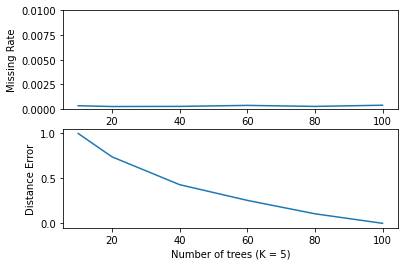

In [189]:
from matplotlib import pyplot as plt 

plt.subplot(211)
plt.xlabel("Number of trees (K = 5)") 
plt.ylabel("Missing Rate") 
plt.ylim(0, 0.01)
plt.plot([10,20,40,60,80,100],avmra) 

plt.subplot(212)
plt.xlabel("Number of trees (K = 5)") 
plt.ylabel("Distance Error") 
plt.plot([10,20,40,60,80,100],avdia) 
plt.show()

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

In [175]:
t = 10
rpf = RPForest(leaf_size=leaf, no_trees=t)
rpf.fit(X_train)

In [182]:
tp = 0
tn = 0
fp = 0
fn = 0

for i in range(len(X_test)):
    neighbors = rpf.query(X_test[i,:], 5)
    n_labels = []
    for n in neighbors:
        n_labels.append(y_train[n][0]) 
    word_counts = Counter(n_labels)
    label = word_counts.most_common(1)

    if label[0][0] == 1 and y_test[i][0] == 1:
        tp += 1
    elif label[0][0] == 1 and y_test[i][0] == -1:
        fp += 1
    elif label[0][0] == -1 and y_test[i][0] == 1:
        fn += 1
    elif label[0][0] == -1 and y_test[i][0] == -1:
        tn += 1
# print(tp, fp, fn, tn)
acc = (tp+tn)/(tp+tn+fp+fn)
pre = (tp)/(tp+fp)
rec = (tp)/(tp+fn)
f1 = 2*(pre*rec)/(pre+rec)

print('rpforest')
print("Accuracy: ", acc)
print("Precision: ", pre)
print("Recall: ", rec)
print('F1 measure: ', f1)

rpforest
Accuracy:  0.9
Precision:  0.9024390243902439
Recall:  0.8604651162790697
F1 measure:  0.8809523809523809


In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

print('Random Forest')
clf = RandomForestClassifier()
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
# print('Confusion matrix: \n',confusion_matrix(y_test, y_pred, labels=None, sample_weight=None))
print('Accuracy: ',accuracy_score(y_test, y_pred))
print('Precision: ',precision_score(y_test, y_pred))
print('Recall: ',recall_score(y_test, y_pred))
print('F1 measure: ',f1_score(y_test, y_pred))


print('\nKNN')
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train.ravel())
y_pred2 = neigh.predict(X_test)
# print('Confusion matrix: \n',confusion_matrix(y_test, y_pred2, labels=None, sample_weight=None))
print('Accuracy: ',accuracy_score(y_test, y_pred2))
print('Precision: ',precision_score(y_test, y_pred2))
print('Recall: ',recall_score(y_test, y_pred2))
print('F1 measure: ',f1_score(y_test, y_pred2))

print('\nrpforest')
print("Accuracy: ", acc)
print("Precision: ", pre)
print("Recall: ", rec)
print('F1 measure: ', f1)

Random Forest
Accuracy:  0.96
Precision:  0.9333333333333333
Recall:  0.9767441860465116
F1 measure:  0.9545454545454545

KNN
Accuracy:  0.87
Precision:  0.8
Recall:  0.9302325581395349
F1 measure:  0.8602150537634408

rpforest
Accuracy:  0.9
Precision:  0.9024390243902439
Recall:  0.8604651162790697
F1 measure:  0.8809523809523809


In [183]:
import prettytable as pt

tb = pt.PrettyTable()
tb.field_names = ["", "Accuracy", "Precision", "Recall","F1 measure"]
tb.add_row(["Random Forest",accuracy_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred),f1_score(y_test, y_pred)])
tb.add_row(["KNN", accuracy_score(y_test, y_pred2),precision_score(y_test, y_pred2),recall_score(y_test, y_pred2),f1_score(y_test, y_pred2)])
tb.add_row(["rpforest",acc,pre,rec,f1])

print(tb)

+---------------+----------+--------------------+--------------------+--------------------+
|               | Accuracy |     Precision      |       Recall       |     F1 measure     |
+---------------+----------+--------------------+--------------------+--------------------+
| Random Forest |   0.96   | 0.9333333333333333 | 0.9767441860465116 | 0.9545454545454545 |
|      KNN      |   0.87   |        0.8         | 0.9302325581395349 | 0.8602150537634408 |
|    rpforest   |   0.9    | 0.9024390243902439 | 0.8604651162790697 | 0.8809523809523809 |
+---------------+----------+--------------------+--------------------+--------------------+
